### Classifying Hazardous Asteroids
- Finding potentially hazardous and nonhazardous asteroids 
- What features are responsible for claiming an asteroid to be hazardous?

#### Approach:
- Run multiple classification models 
- Use flask to create something interactive that will let a user search for asteroids based on their closest approach date to Earth

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

sns.set_style("whitegrid")


In [4]:
df = pd.read_csv('../data/NASA-asteroid-classification.csv')

In [5]:
df.head()

full_name       name neo pha   epoch_cal equinox  \
0          433 Eros (1898 DQ)       Eros   Y   N  20200531.0   J2000   
1      588 Achilles (1906 TG)   Achilles   N   N  20200531.0   J2000   
2     617 Patroclus (1906 VY)  Patroclus   N   N  20200531.0   J2000   
3        624 Hektor (1907 XM)     Hektor   N   N  20200531.0   J2000   
4        659 Nestor (1908 CS)     Nestor   N   N  20200531.0   J2000   

          e         a         q          i  ...         n      moid  t_jup  \
0  0.222951  1.458046  1.132973  10.830543  ...  0.559819  0.148623  4.582   
1  0.147122  5.209394  4.442980  10.319724  ...  0.082894  3.470060  2.946   
2  0.138967  5.214560  4.489910  22.051776  ...  0.082771  3.537570  2.836   
3  0.022797  5.262260  5.142298  18.157697  ...  0.081648  4.149850  2.899   
4  0.117448  5.164464  4.557910   4.522630  ...  0.083978  3.548340  2.980   

           om          per      per_y  class      producer   first_obs  \
0  304.299327   643.065402   1.760617    AMO      Giorgini  1893-10-29   
1  316.536049  4342.893776  11.890195    TJN    Otto Matic  1906-02-22   
2   44.348414  4349.355185  11.907886    TJN  Ryan S. Park  1998-04-22   
3  342.791035  4409.170054  12.071650    TJN    Otto Matic  1907-02-11   
4  350.739111  4286.830857  11.736703    TJN    Otto Matic  1908-03-23   

     last_obs  
0  2019-02-13  
1  2020-01-06  
2  2019-08-17  
3  2020-01-26  
4  2020-01-06  

[5 rows x 24 columns]

In [6]:
df.shape

(7856, 24)

In [7]:
# Check if there are null values
df.isnull().sum()

full_name       0
name         7442
neo             0
pha             0
epoch_cal       0
equinox         0
e               0
a               0
q               0
i               0
w               0
H               0
ma              0
ad              0
n               0
moid            0
t_jup           0
om              0
per             0
per_y           0
class           0
producer        0
first_obs       0
last_obs        0
dtype: int64

In [8]:
# Create column name dictionary to rename columns
column_names = {
    'pha': 'hazardous',
    'e': 'eccentricity_(e)',
    'a': 'semi_major_axis_(a)',
    'q': 'perihelion_dist_(q)',
    'i': 'inclination_(i)',
    'w': 'perihelion_arg_(w)',
    'H': 'abs_magnitude_(H)',
    'ma': 'mean_anomaly',
    'ad': 'aphelion_dist_(Q)',
    'n': 'mean_motion_(n)',
    'moid': 'min_orbit_intersection_dist',
    't_jup': 't_jupiter',
    'per': 'orbital_per_(d)',
    'per_y': 'orbital_per_(y)',
    'om': 'asc_node_long_(deg)'
}

# Rename columns
df.rename(columns=column_names, inplace=True)

In [9]:
# Drop name column because it's a repitition of full_name column but with most values missing
# Drop producer because it's unbalanced and won't contribute to the model 
# Drop equinox because all observations have the same equinox 'J2000'
df.drop(columns=['name', 'producer', 'equinox'], inplace=True)

# Verify there are no more missing values
df.isnull().sum()

full_name                      0
neo                            0
hazardous                      0
epoch_cal                      0
eccentricity_(e)               0
semi_major_axis_(a)            0
perihelion_dist_(q)            0
inclination_(i)                0
perihelion_arg_(w)             0
abs_magnitude_(H)              0
mean_anomaly                   0
aphelion_dist_(Q)              0
mean_motion_(n)                0
min_orbit_intersection_dist    0
t_jupiter                      0
asc_node_long_(deg)            0
orbital_per_(d)                0
orbital_per_(y)                0
class                          0
first_obs                      0
last_obs                       0
dtype: int64

In [10]:
# Inspect the data types
df.dtypes

full_name                       object
neo                             object
hazardous                       object
epoch_cal                      float64
eccentricity_(e)               float64
semi_major_axis_(a)            float64
perihelion_dist_(q)            float64
inclination_(i)                float64
perihelion_arg_(w)             float64
abs_magnitude_(H)              float64
mean_anomaly                   float64
aphelion_dist_(Q)              float64
mean_motion_(n)                float64
min_orbit_intersection_dist    float64
t_jupiter                      float64
asc_node_long_(deg)            float64
orbital_per_(d)                float64
orbital_per_(y)                float64
class                           object
first_obs                       object
last_obs                        object
dtype: object

In [11]:
df.head()

full_name neo hazardous   epoch_cal  eccentricity_(e)  \
0          433 Eros (1898 DQ)   Y         N  20200531.0          0.222951   
1      588 Achilles (1906 TG)   N         N  20200531.0          0.147122   
2     617 Patroclus (1906 VY)   N         N  20200531.0          0.138967   
3        624 Hektor (1907 XM)   N         N  20200531.0          0.022797   
4        659 Nestor (1908 CS)   N         N  20200531.0          0.117448   

   semi_major_axis_(a)  perihelion_dist_(q)  inclination_(i)  \
0             1.458046             1.132973        10.830543   
1             5.209394             4.442980        10.319724   
2             5.214560             4.489910        22.051776   
3             5.262260             5.142298        18.157697   
4             5.164464             4.557910         4.522630   

   perihelion_arg_(w)  abs_magnitude_(H)  ...  aphelion_dist_(Q)  \
0          178.882294               10.4  ...           1.783119   
1          133.308510                8.3  ...           5.975808   
2          307.866082                8.2  ...           5.939209   
3          184.243883                7.2  ...           5.382221   
4          343.462149                8.7  ...           5.771019   

   mean_motion_(n)  min_orbit_intersection_dist  t_jupiter  \
0         0.559819                     0.148623      4.582   
1         0.082894                     3.470060      2.946   
2         0.082771                     3.537570      2.836   
3         0.081648                     4.149850      2.899   
4         0.083978                     3.548340      2.980   

   asc_node_long_(deg)  orbital_per_(d)  orbital_per_(y)  class   first_obs  \
0           304.299327       643.065402         1.760617    AMO  1893-10-29   
1           316.536049      4342.893776        11.890195    TJN  1906-02-22   
2            44.348414      4349.355185        11.907886    TJN  1998-04-22   
3           342.791035      4409.170054        12.071650    TJN  1907-02-11   
4           350.739111      4286.830857        11.736703    TJN  1908-03-23   

     last_obs  
0  2019-02-13  
1  2020-01-06  
2  2019-08-17  
3  2020-01-26  
4  2020-01-06  

[5 rows x 21 columns]

In [12]:
# Convert datetime columns to pandas datetime data types 
df['first_obs'] = pd.to_datetime(df['first_obs'])
df['last_obs'] = pd.to_datetime(df['last_obs'])

# Check that it worked
df.dtypes

full_name                              object
neo                                    object
hazardous                              object
epoch_cal                             float64
eccentricity_(e)                      float64
semi_major_axis_(a)                   float64
perihelion_dist_(q)                   float64
inclination_(i)                       float64
perihelion_arg_(w)                    float64
abs_magnitude_(H)                     float64
mean_anomaly                          float64
aphelion_dist_(Q)                     float64
mean_motion_(n)                       float64
min_orbit_intersection_dist           float64
t_jupiter                             float64
asc_node_long_(deg)                   float64
orbital_per_(d)                       float64
orbital_per_(y)                       float64
class                                  object
first_obs                      datetime64[ns]
last_obs                       datetime64[ns]
dtype: object

In [13]:
# Assign target labels (hazardous)
# Assign NEO labels
df['hazardous'] = df['hazardous'].map({'Y': 1, 'N': 0})
df['neo'] = df['neo'].map({'Y': 1, 'N': 0})

df['hazardous'].value_counts()

0    7093
1     763
Name: hazardous, dtype: int64

In [14]:
df['neo'].value_counts()

0    4945
1    2911
Name: neo, dtype: int64

In [15]:
df.dtypes

full_name                              object
neo                                     int64
hazardous                               int64
epoch_cal                             float64
eccentricity_(e)                      float64
semi_major_axis_(a)                   float64
perihelion_dist_(q)                   float64
inclination_(i)                       float64
perihelion_arg_(w)                    float64
abs_magnitude_(H)                     float64
mean_anomaly                          float64
aphelion_dist_(Q)                     float64
mean_motion_(n)                       float64
min_orbit_intersection_dist           float64
t_jupiter                             float64
asc_node_long_(deg)                   float64
orbital_per_(d)                       float64
orbital_per_(y)                       float64
class                                  object
first_obs                      datetime64[ns]
last_obs                       datetime64[ns]
dtype: object

In [16]:
df['class'].value_counts()

TJN    4945
APO    1473
AMO    1201
ATE     237
Name: class, dtype: int64

In [17]:
# get dummies for each asteroid class
# AMO was dropped
# df = pd.get_dummies(df, columns=['class'], drop_first=True)

In [18]:
df.head()

full_name  neo  hazardous   epoch_cal  eccentricity_(e)  \
0          433 Eros (1898 DQ)    1          0  20200531.0          0.222951   
1      588 Achilles (1906 TG)    0          0  20200531.0          0.147122   
2     617 Patroclus (1906 VY)    0          0  20200531.0          0.138967   
3        624 Hektor (1907 XM)    0          0  20200531.0          0.022797   
4        659 Nestor (1908 CS)    0          0  20200531.0          0.117448   

   semi_major_axis_(a)  perihelion_dist_(q)  inclination_(i)  \
0             1.458046             1.132973        10.830543   
1             5.209394             4.442980        10.319724   
2             5.214560             4.489910        22.051776   
3             5.262260             5.142298        18.157697   
4             5.164464             4.557910         4.522630   

   perihelion_arg_(w)  abs_magnitude_(H)  ...  aphelion_dist_(Q)  \
0          178.882294               10.4  ...           1.783119   
1          133.308510                8.3  ...           5.975808   
2          307.866082                8.2  ...           5.939209   
3          184.243883                7.2  ...           5.382221   
4          343.462149                8.7  ...           5.771019   

   mean_motion_(n)  min_orbit_intersection_dist  t_jupiter  \
0         0.559819                     0.148623      4.582   
1         0.082894                     3.470060      2.946   
2         0.082771                     3.537570      2.836   
3         0.081648                     4.149850      2.899   
4         0.083978                     3.548340      2.980   

   asc_node_long_(deg)  orbital_per_(d)  orbital_per_(y)  class  first_obs  \
0           304.299327       643.065402         1.760617    AMO 1893-10-29   
1           316.536049      4342.893776        11.890195    TJN 1906-02-22   
2            44.348414      4349.355185        11.907886    TJN 1998-04-22   
3           342.791035      4409.170054        12.071650    TJN 1907-02-11   
4           350.739111      4286.830857        11.736703    TJN 1908-03-23   

    last_obs  
0 2019-02-13  
1 2020-01-06  
2 2019-08-17  
3 2020-01-26  
4 2020-01-06  

[5 rows x 21 columns]

In [19]:
cols = list(df.columns)

[Astronomical Unit](https://cneos.jpl.nasa.gov/glossary/au.html)  
[Lunar Distance](https://cneos.jpl.nasa.gov/glossary/LD.html)  
[True Anomoly](https://cneos.jpl.nasa.gov/glossary/true_anomaly.html)  
[Perihelion](https://cneos.jpl.nasa.gov/glossary/perihelion.html)  
[Absolute Magnitude](https://cneos.jpl.nasa.gov/glossary/h.html)
[Jupiter Tisserand Invariant](https://pdssbn.astro.umd.edu/about/what_r_sb.shtml)  
[Tisserand Parameter](http://www2.ess.ucla.edu/~jewitt/tisserand.html)

>\begin{equation}
T_J = \frac{a_J}{a} + 2 \left[(1 - e^2)\frac{a}{a_J}\right]^{1/2} \cos(i)
\end{equation}  

[Mean Anomaly](http://www.columbia.edu/~my2317/asteroidproject.html)
[Epoch](https://en.wikipedia.org/wiki/Epoch_(astronomy))

https://cneos.jpl.nasa.gov/sentry/intro.html  
https://pdssbn.astro.umd.edu/about/what_r_sb.shtml

In [20]:
cols

['full_name',
 'neo',
 'hazardous',
 'epoch_cal',
 'eccentricity_(e)',
 'semi_major_axis_(a)',
 'perihelion_dist_(q)',
 'inclination_(i)',
 'perihelion_arg_(w)',
 'abs_magnitude_(H)',
 'mean_anomaly',
 'aphelion_dist_(Q)',
 'mean_motion_(n)',
 'min_orbit_intersection_dist',
 't_jupiter',
 'asc_node_long_(deg)',
 'orbital_per_(d)',
 'orbital_per_(y)',
 'class',
 'first_obs',
 'last_obs']

In [21]:
def subplot_histograms(dataframe, list_of_columns, list_of_titles, list_of_xlabels):
    nrows = int(np.ceil(len(list_of_columns)/2)) # Makes sure you have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize = (10,10), dpi = 90) # You'll want to specify your figsize
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    colors = ['#7F7FFF', '#7F7FFF', '#7F7FFF', '#7F7FFF']
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        ax[i].hist(dataframe[column], color = colors[i]) # feel free to add more settings
        # Set titles, labels, etc for each subplot
    for i, title in enumerate(list_of_titles):
        ax[i].set(title=f'{title} Histogram')
    for i, xlabel in enumerate(list_of_xlabels):
        ax[i].set(xlabel=xlabel)
    plt.subplots_adjust(hspace=0.3)
    
#     '#7F7FFF', '#FCBFB8', '#7F7FFF', '#FCBFB8'

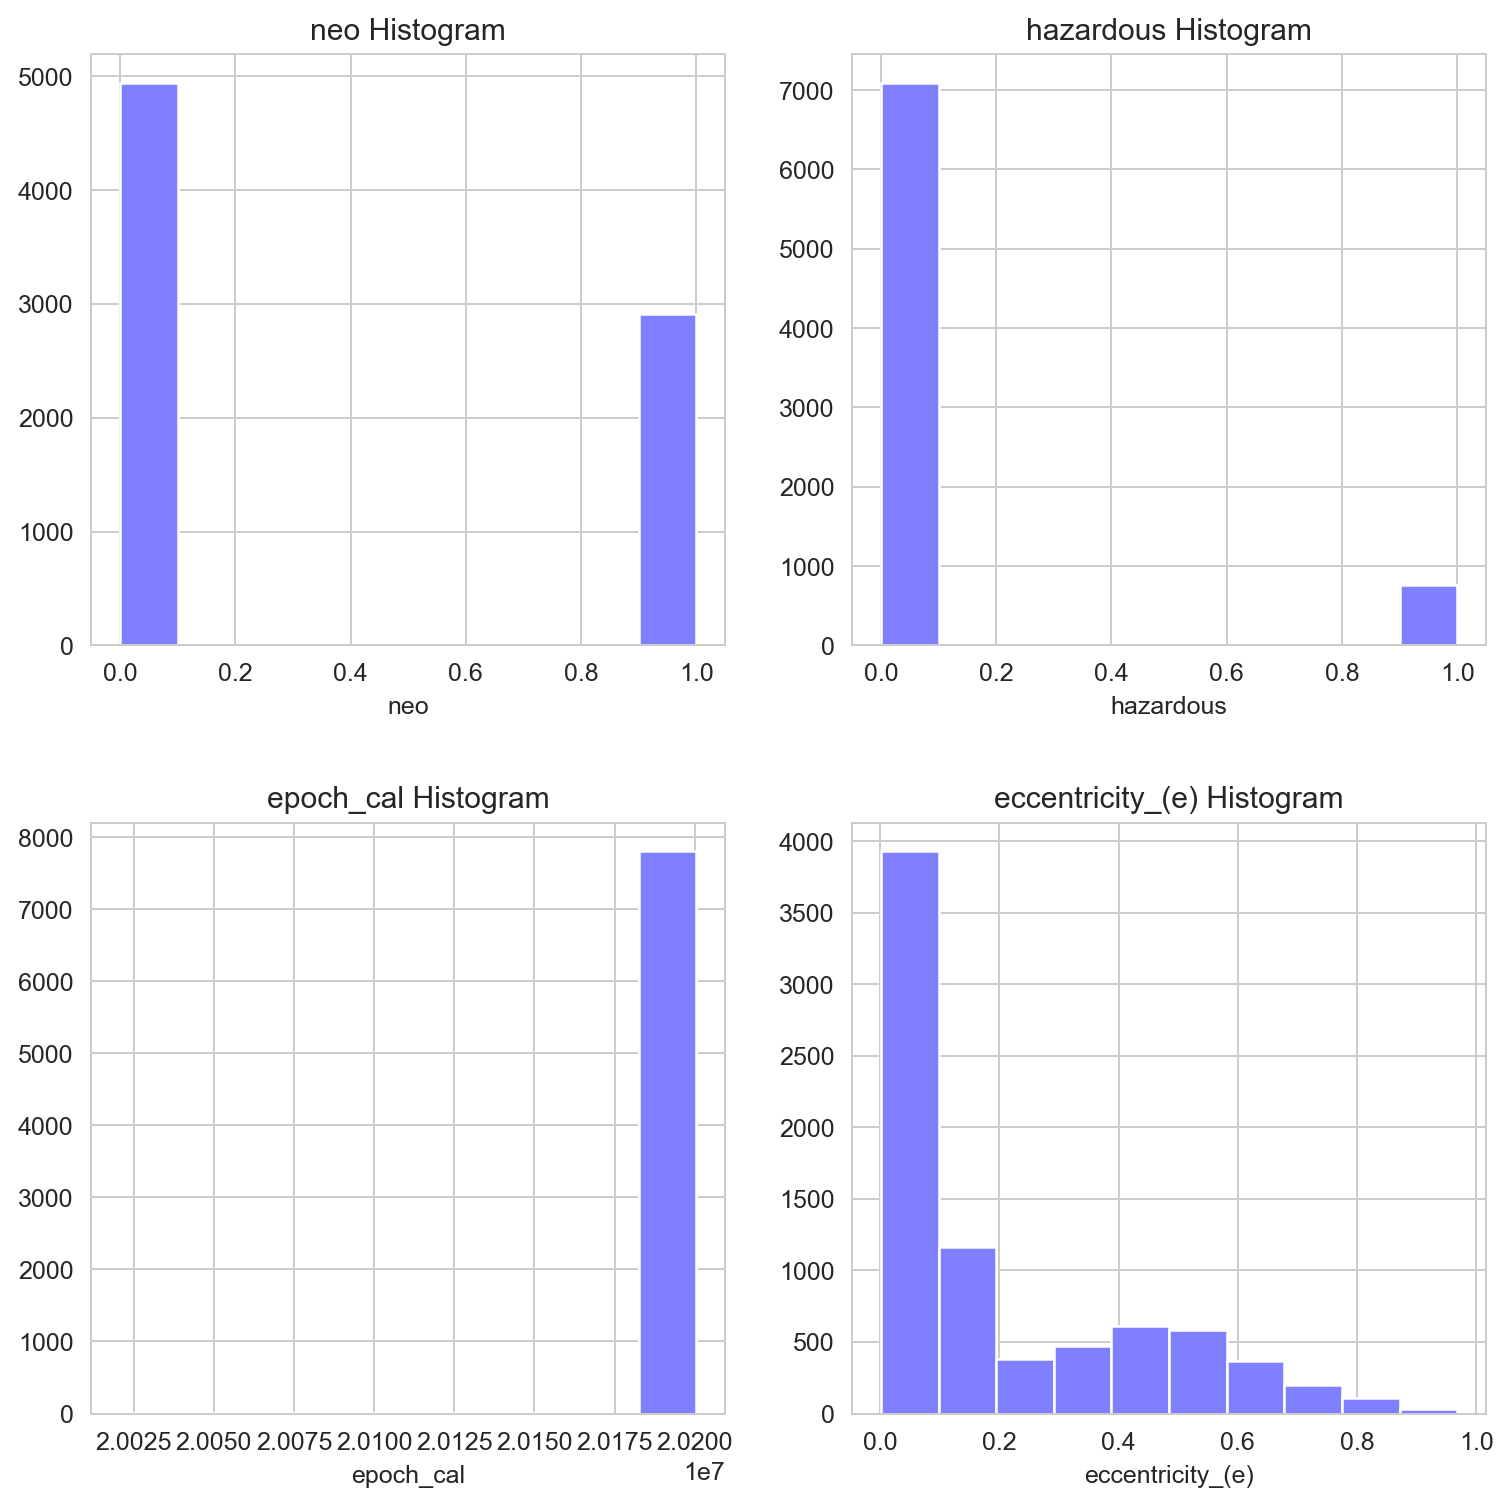

In [22]:
subplot_histograms(df,
                   ['neo', 'hazardous', 'epoch_cal', 'eccentricity_(e)'],
                   ['neo', 'hazardous', 'epoch_cal', 'eccentricity_(e)'],
                   ['neo', 'hazardous', 'epoch_cal', 'eccentricity_(e)']
                  )

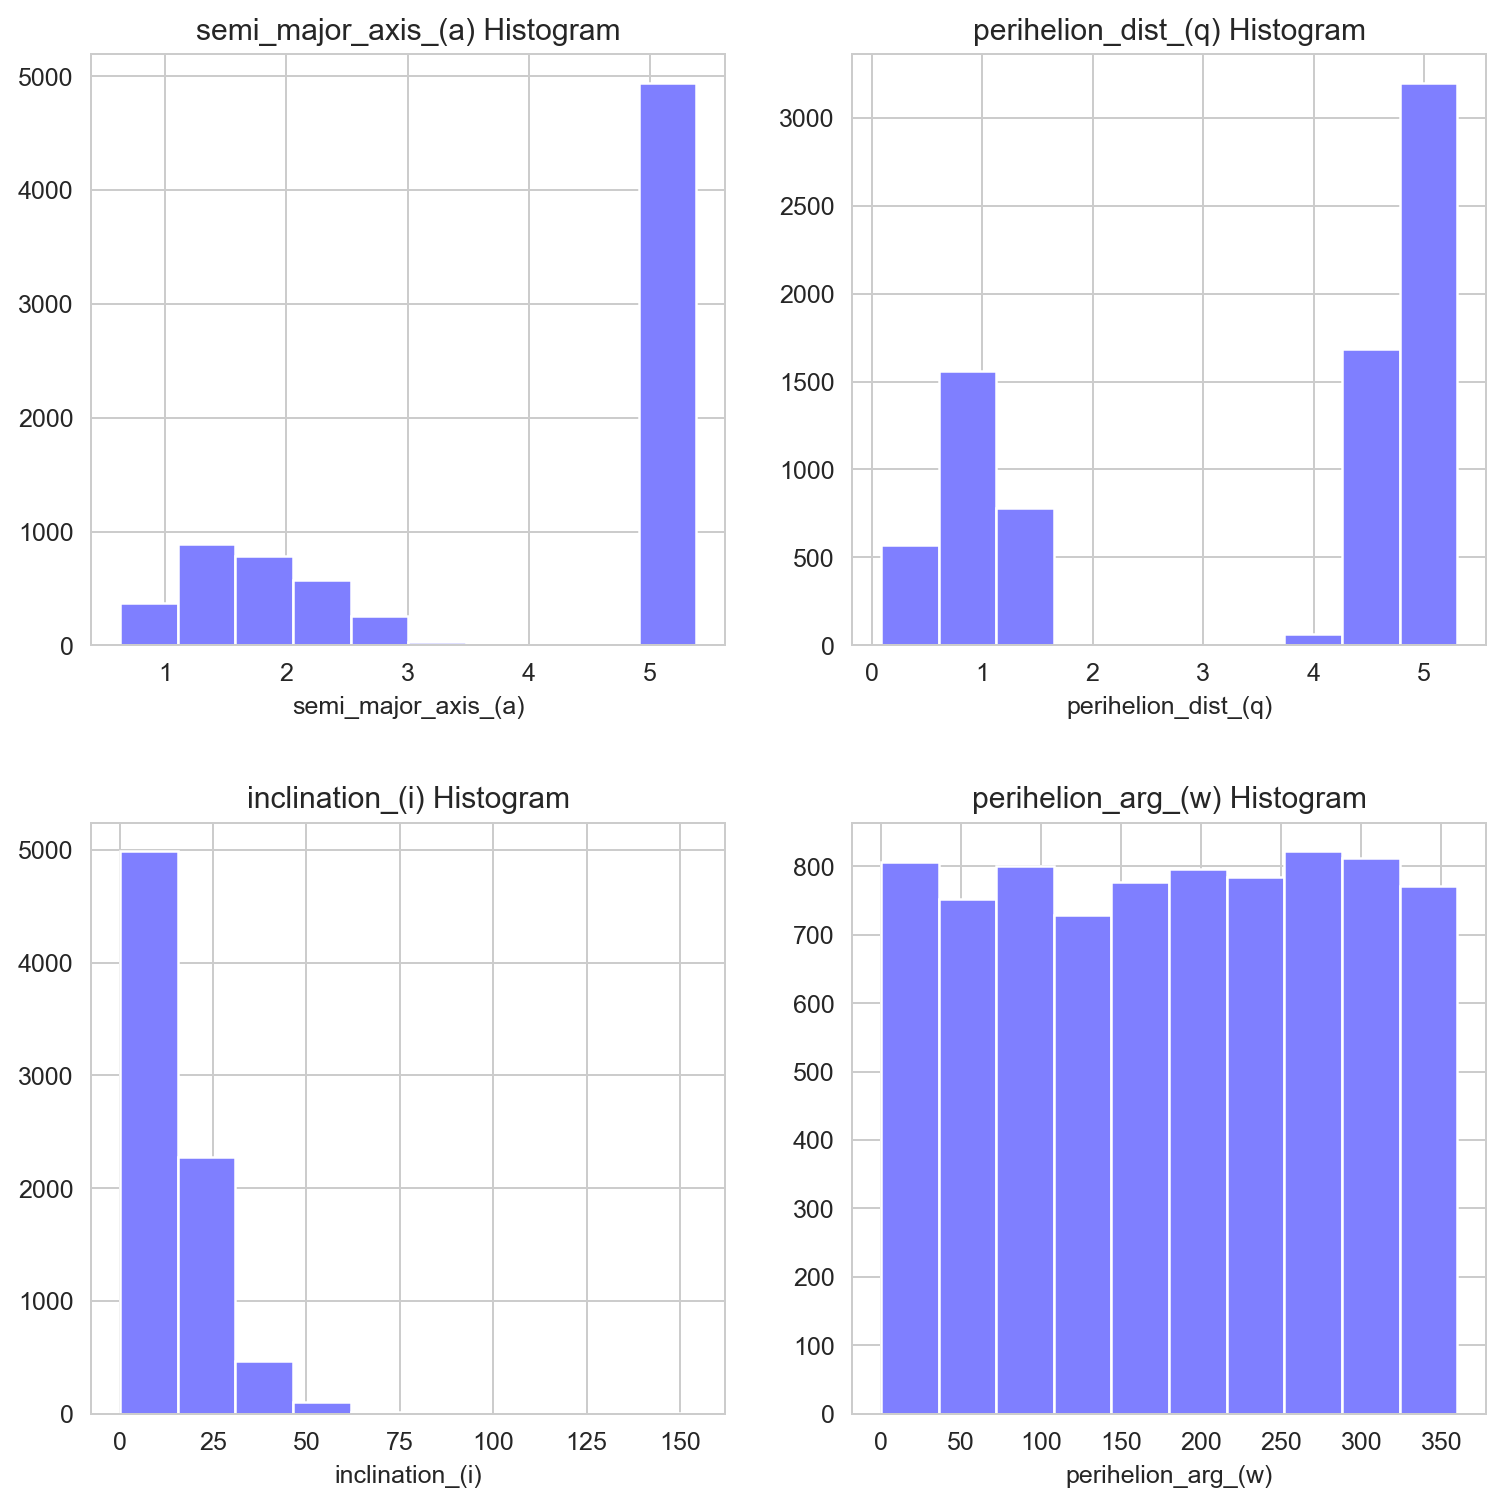

In [23]:
subplot_histograms(df,
                   ['semi_major_axis_(a)', 'perihelion_dist_(q)', 'inclination_(i)', 'perihelion_arg_(w)'],
                   ['semi_major_axis_(a)', 'perihelion_dist_(q)', 'inclination_(i)', 'perihelion_arg_(w)'],
                   ['semi_major_axis_(a)', 'perihelion_dist_(q)', 'inclination_(i)', 'perihelion_arg_(w)']
                  )

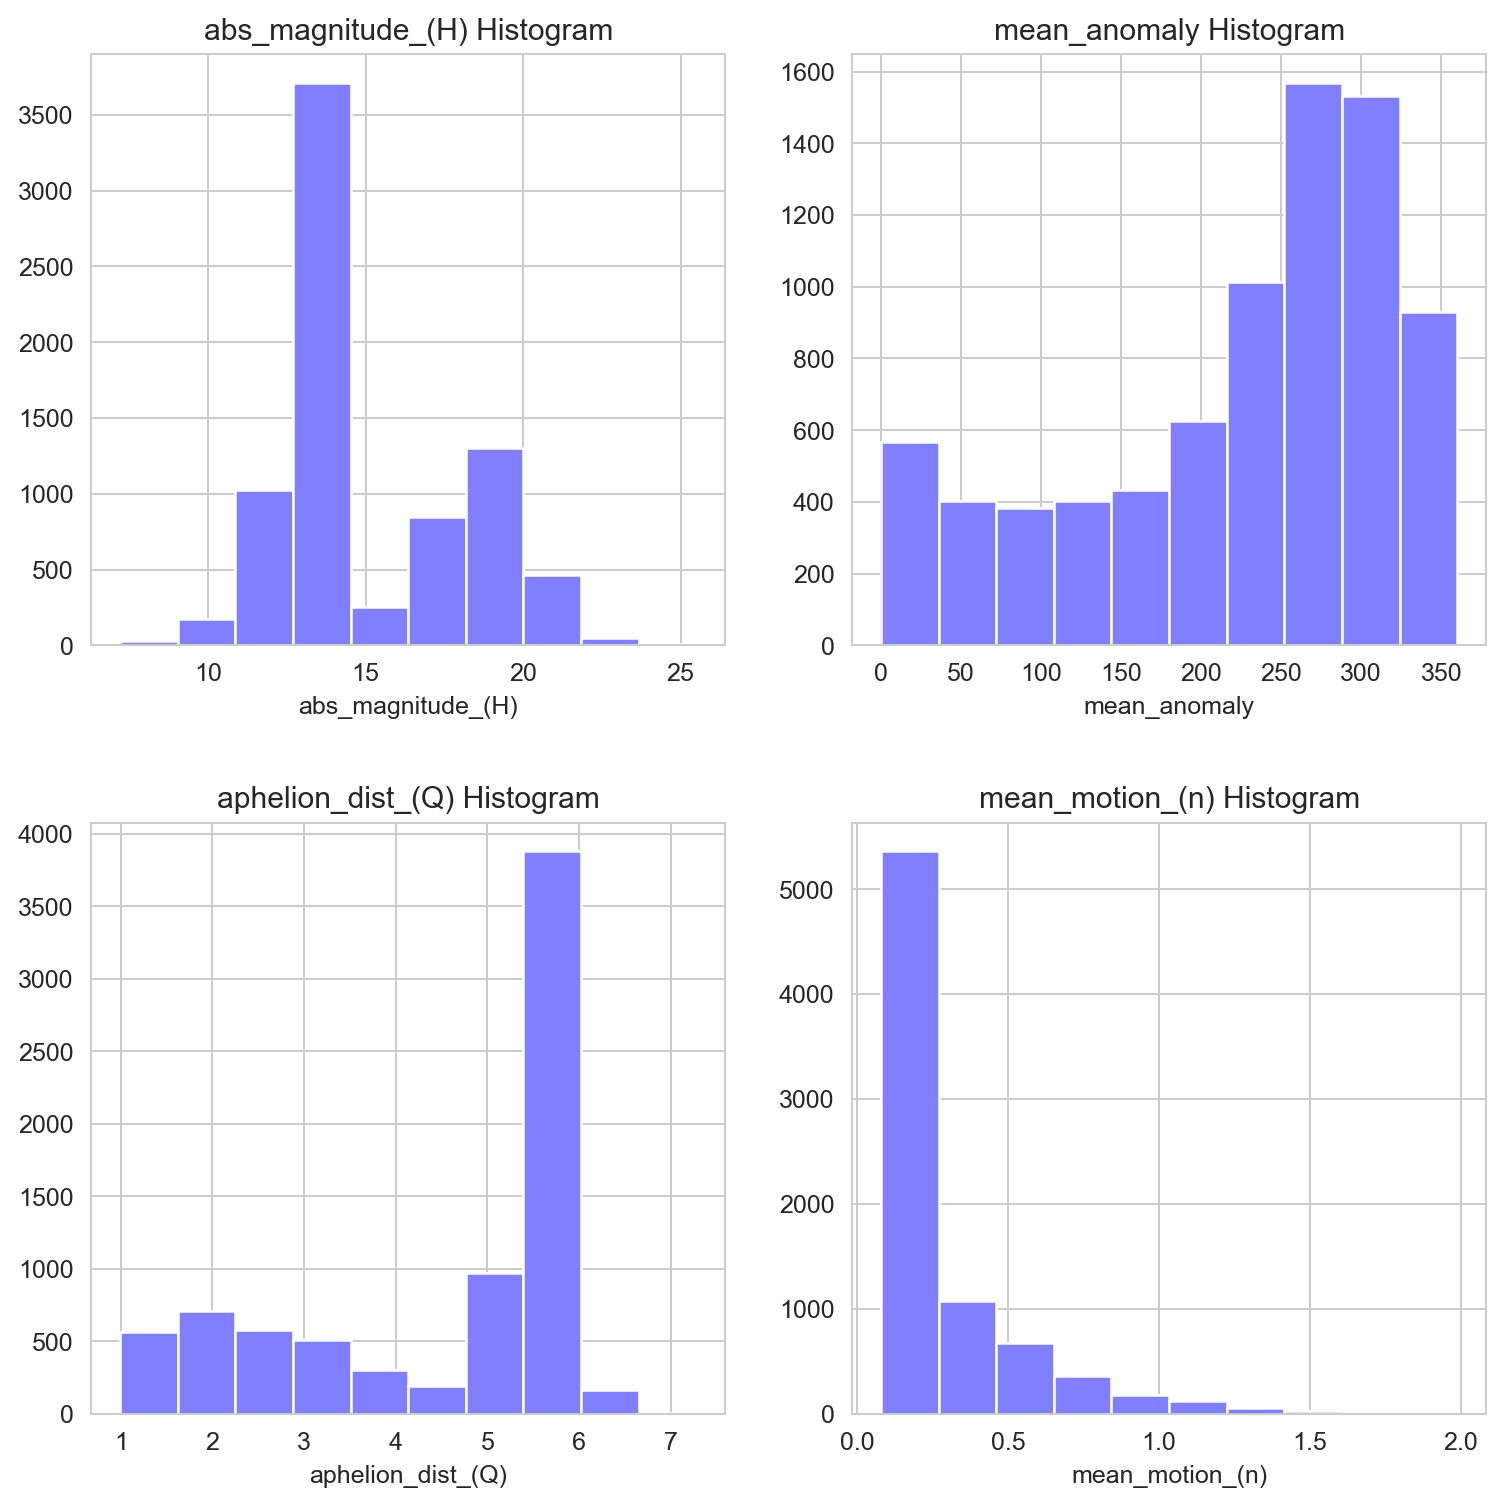

In [24]:
subplot_histograms(df,
                  ['abs_magnitude_(H)', 'mean_anomaly', 'aphelion_dist_(Q)', 'mean_motion_(n)'],
                  ['abs_magnitude_(H)', 'mean_anomaly', 'aphelion_dist_(Q)', 'mean_motion_(n)'],
                  ['abs_magnitude_(H)', 'mean_anomaly', 'aphelion_dist_(Q)', 'mean_motion_(n)']
                  )

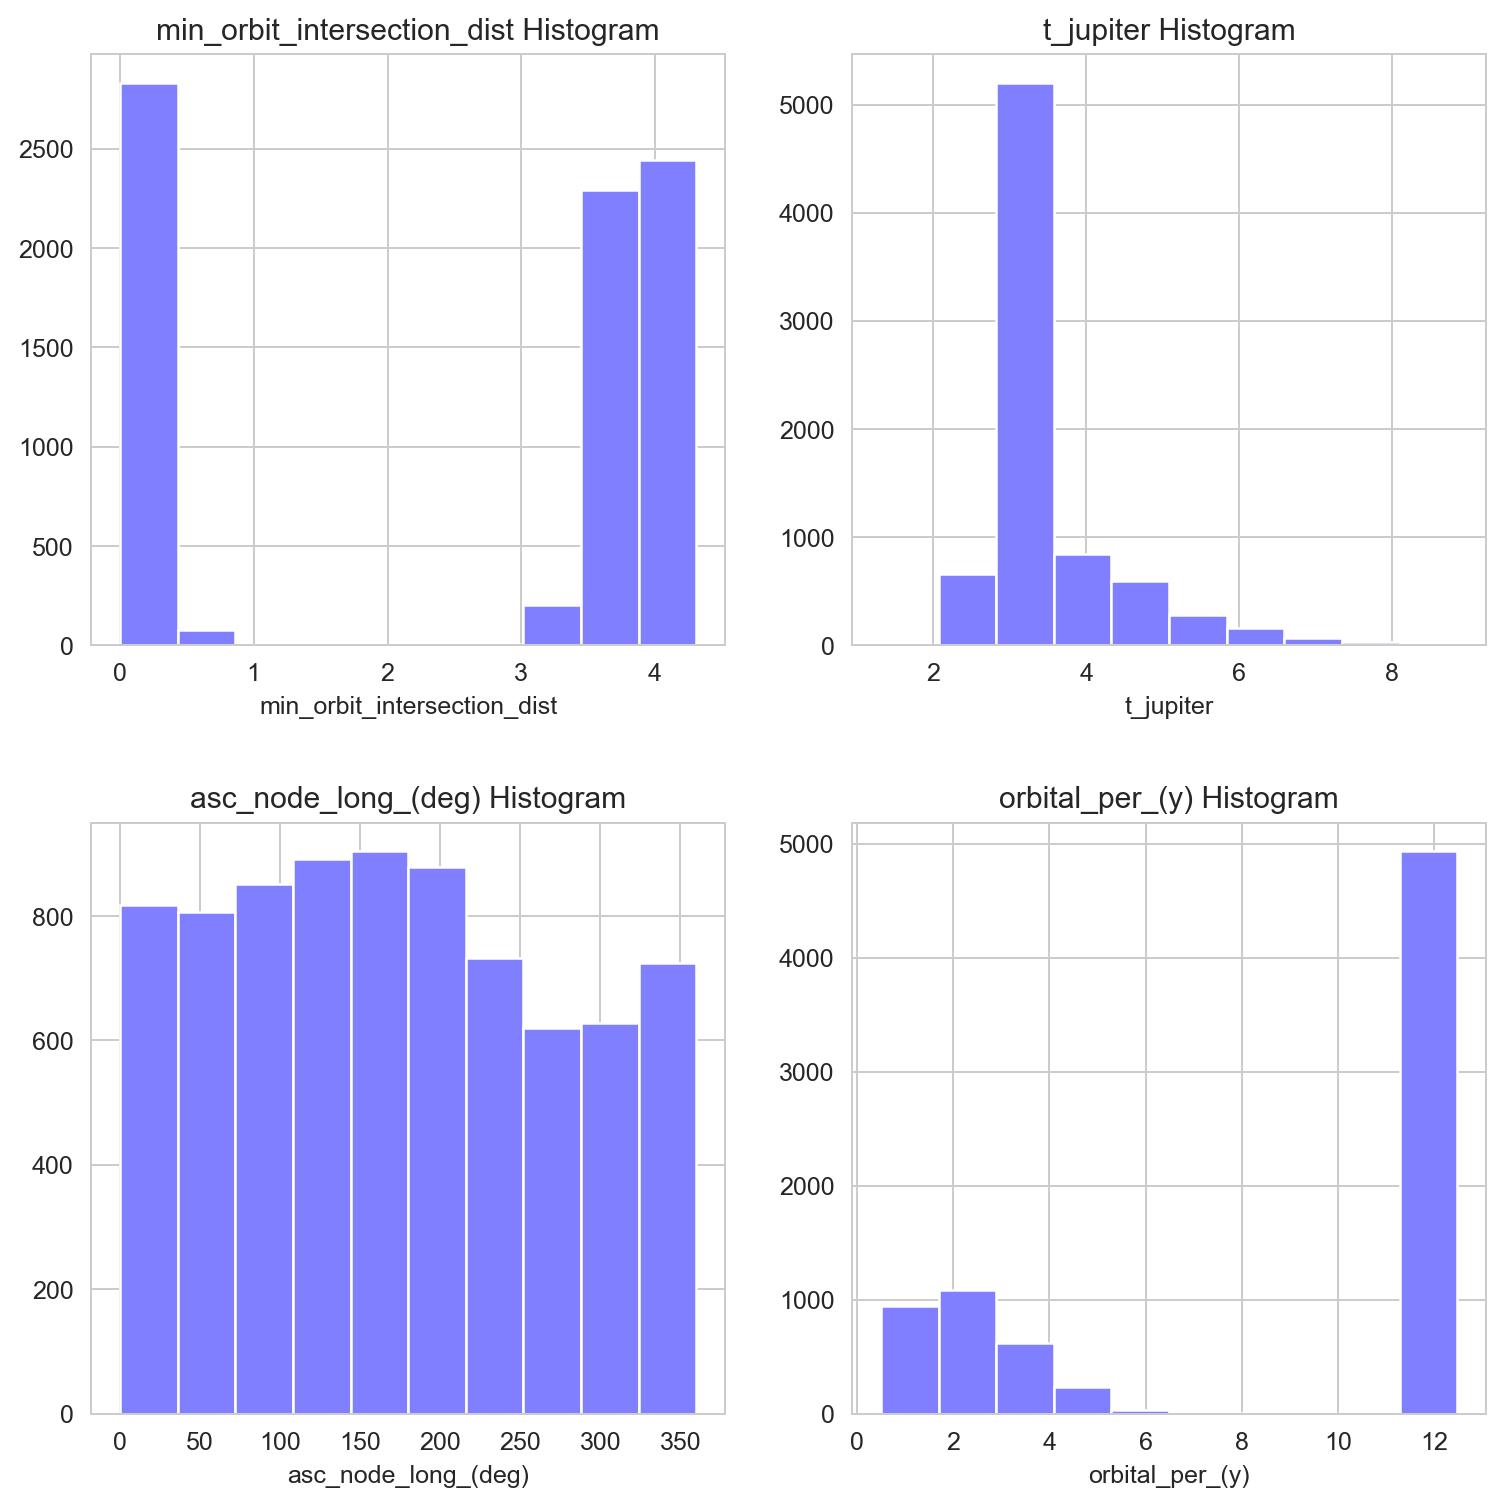

In [25]:
subplot_histograms(df,
                  ['min_orbit_intersection_dist', 't_jupiter', 'asc_node_long_(deg)', 'orbital_per_(y)'],
                  ['min_orbit_intersection_dist', 't_jupiter', 'asc_node_long_(deg)', 'orbital_per_(y)'],
                  ['min_orbit_intersection_dist', 't_jupiter', 'asc_node_long_(deg)', 'orbital_per_(y)'])

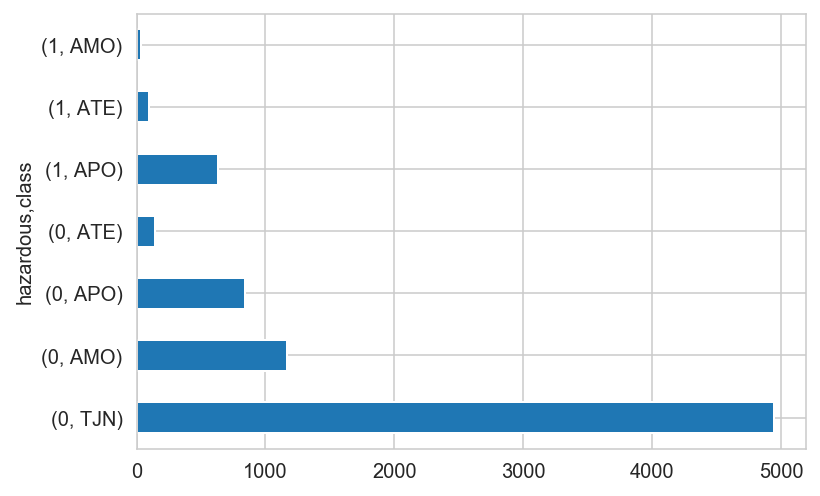

In [26]:
df.groupby('hazardous')['class'].value_counts().plot(kind='barh')

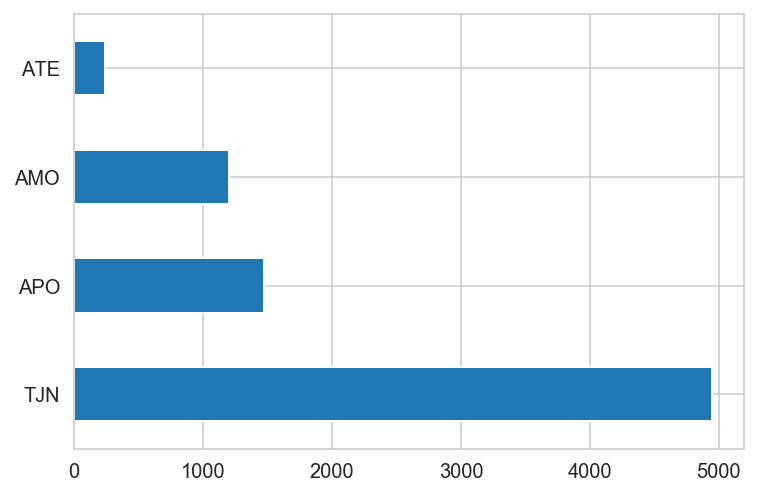

In [27]:
df.sort_values(by='hazardous')['class'].value_counts().plot(kind='barh')

In [28]:
df.describe().columns

Index(['neo', 'hazardous', 'epoch_cal', 'eccentricity_(e)',
       'semi_major_axis_(a)', 'perihelion_dist_(q)', 'inclination_(i)',
       'perihelion_arg_(w)', 'abs_magnitude_(H)', 'mean_anomaly',
       'aphelion_dist_(Q)', 'mean_motion_(n)', 'min_orbit_intersection_dist',
       't_jupiter', 'asc_node_long_(deg)', 'orbital_per_(d)',
       'orbital_per_(y)'],
      dtype='object')

In [29]:
def plot_scatterplot(dataframe, list_of_columns, title, xlabel, ylabel):
    plt.figure(figsize=(8, 5), dpi=80)
    plt.scatter(dataframe[list_of_columns[0]],
            dataframe[list_of_columns[1]], c= '#7F7FFF')
    plt.title(title, fontsize=18)
    plt.xlabel(xlabel, fontsize = 12)
    plt.ylabel(ylabel, fontsize=12);

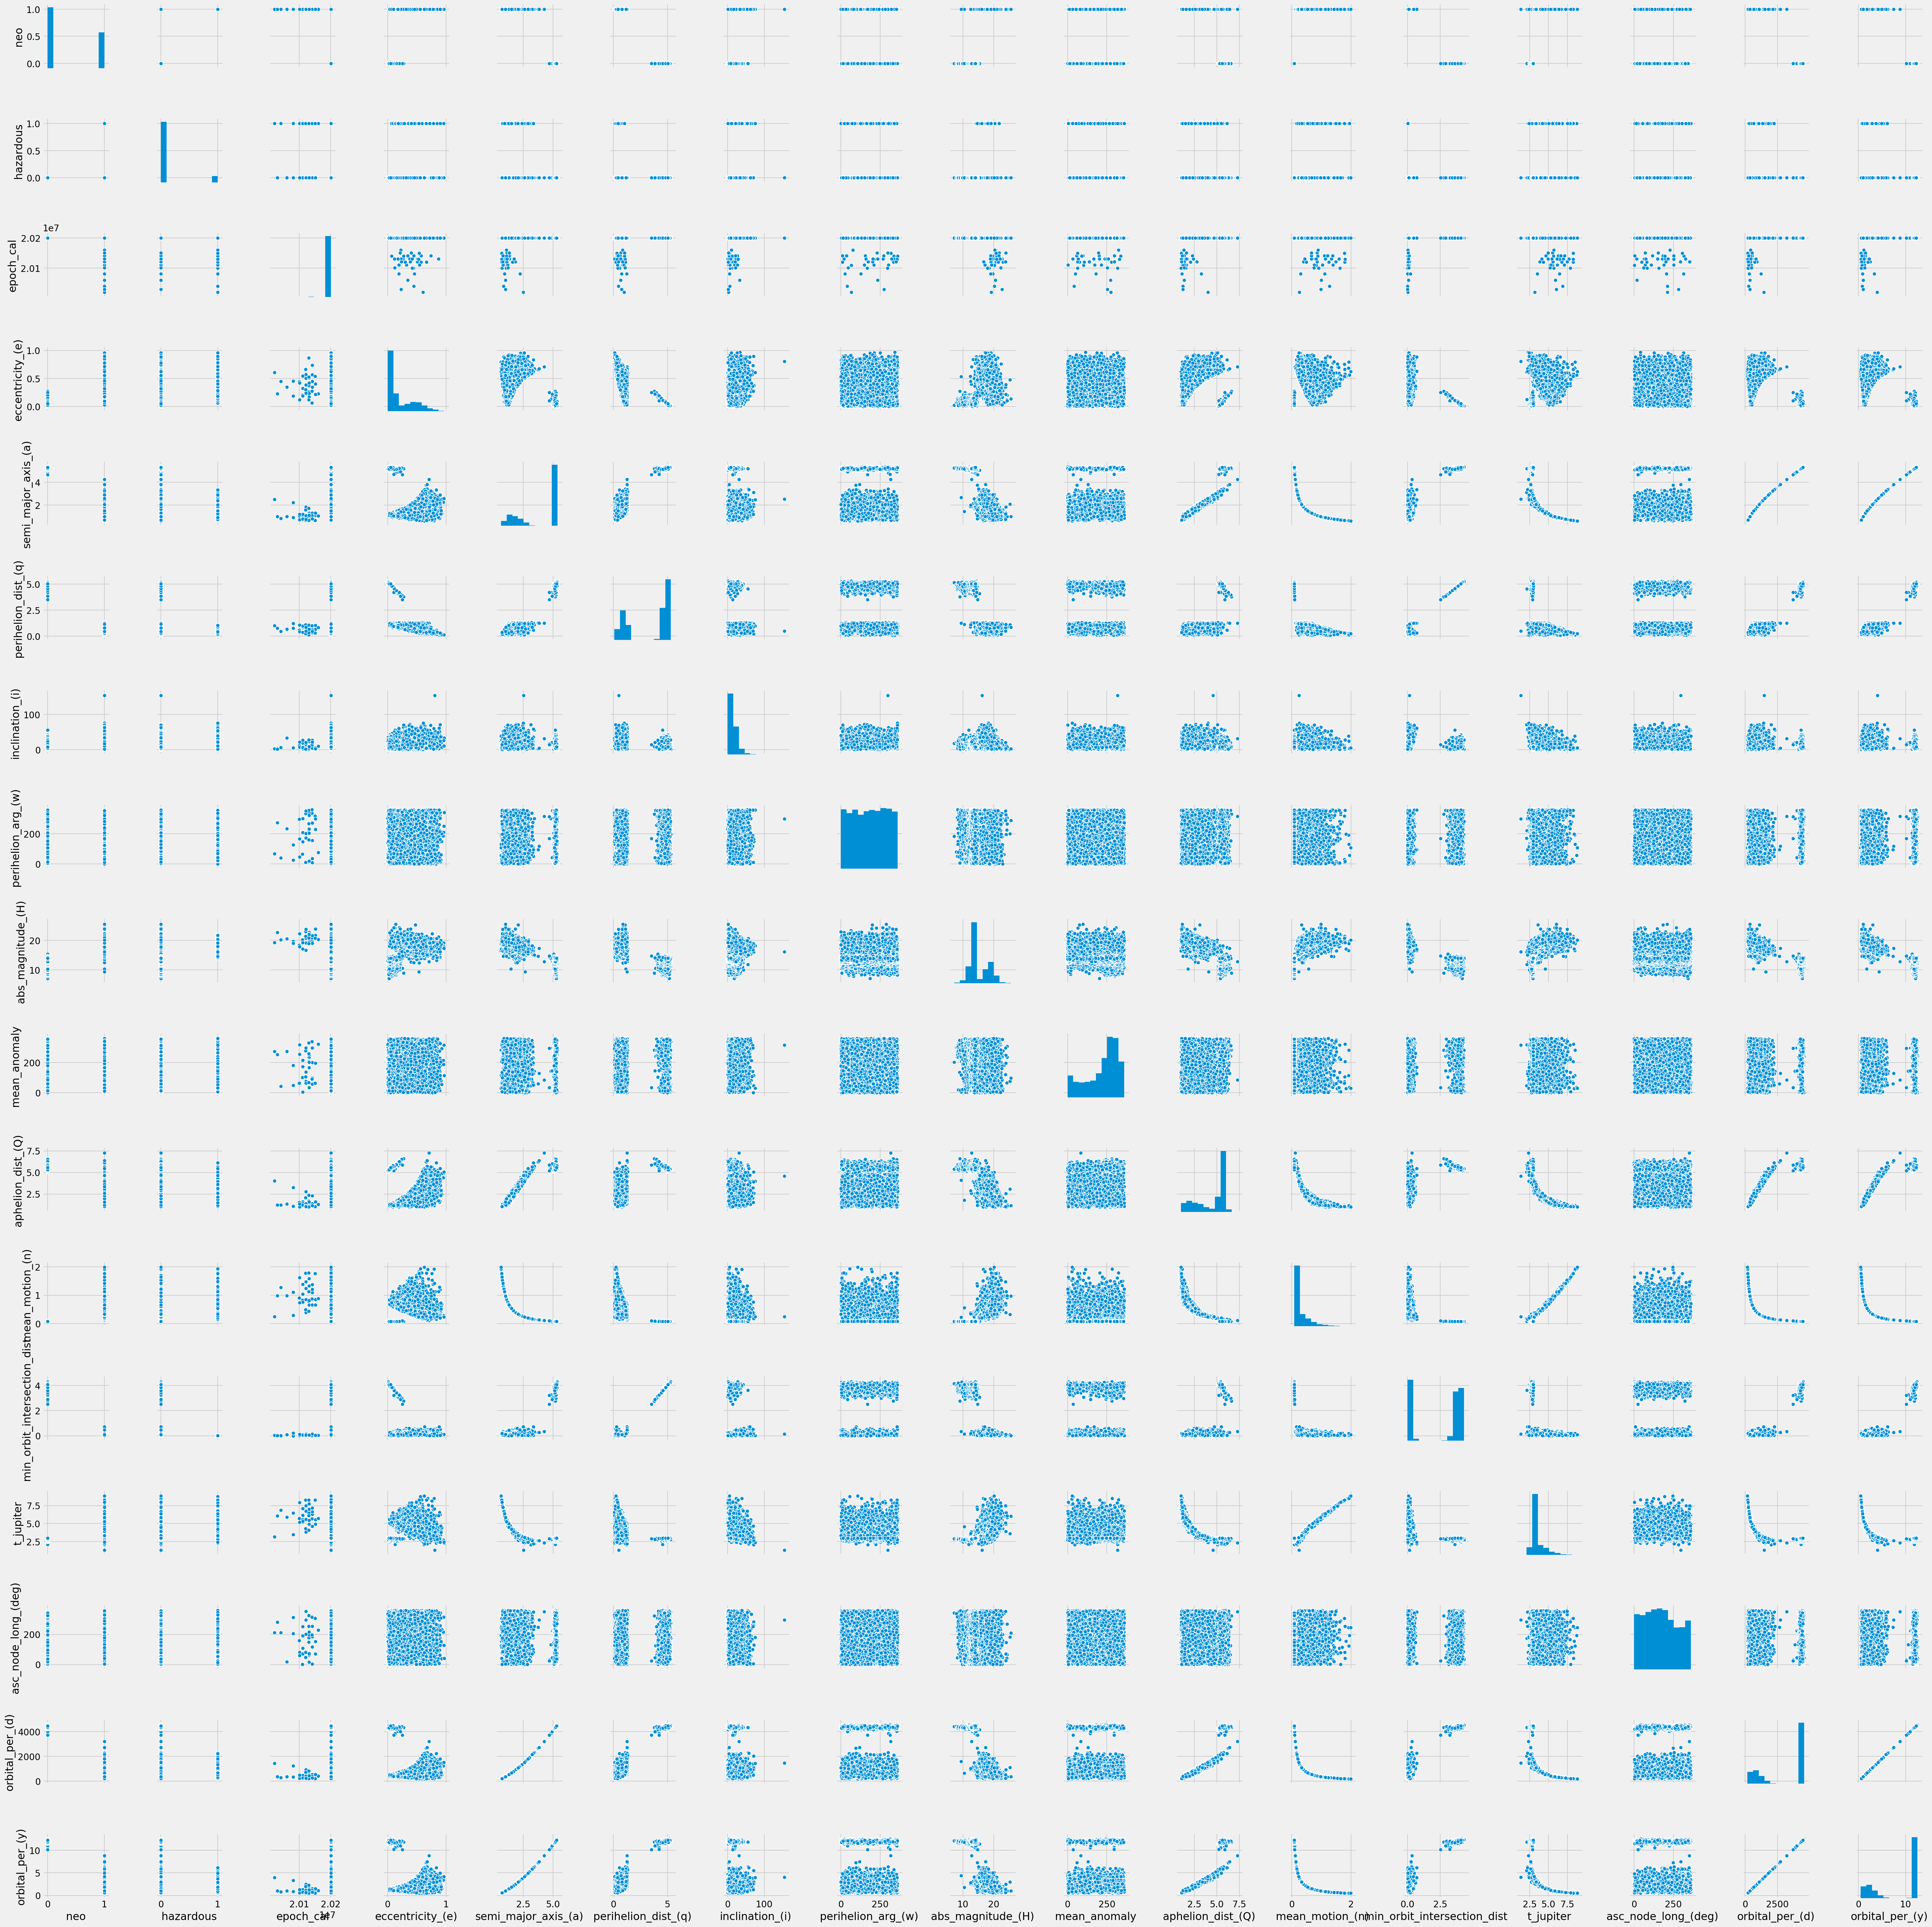

In [182]:
sns.pairplot(df);

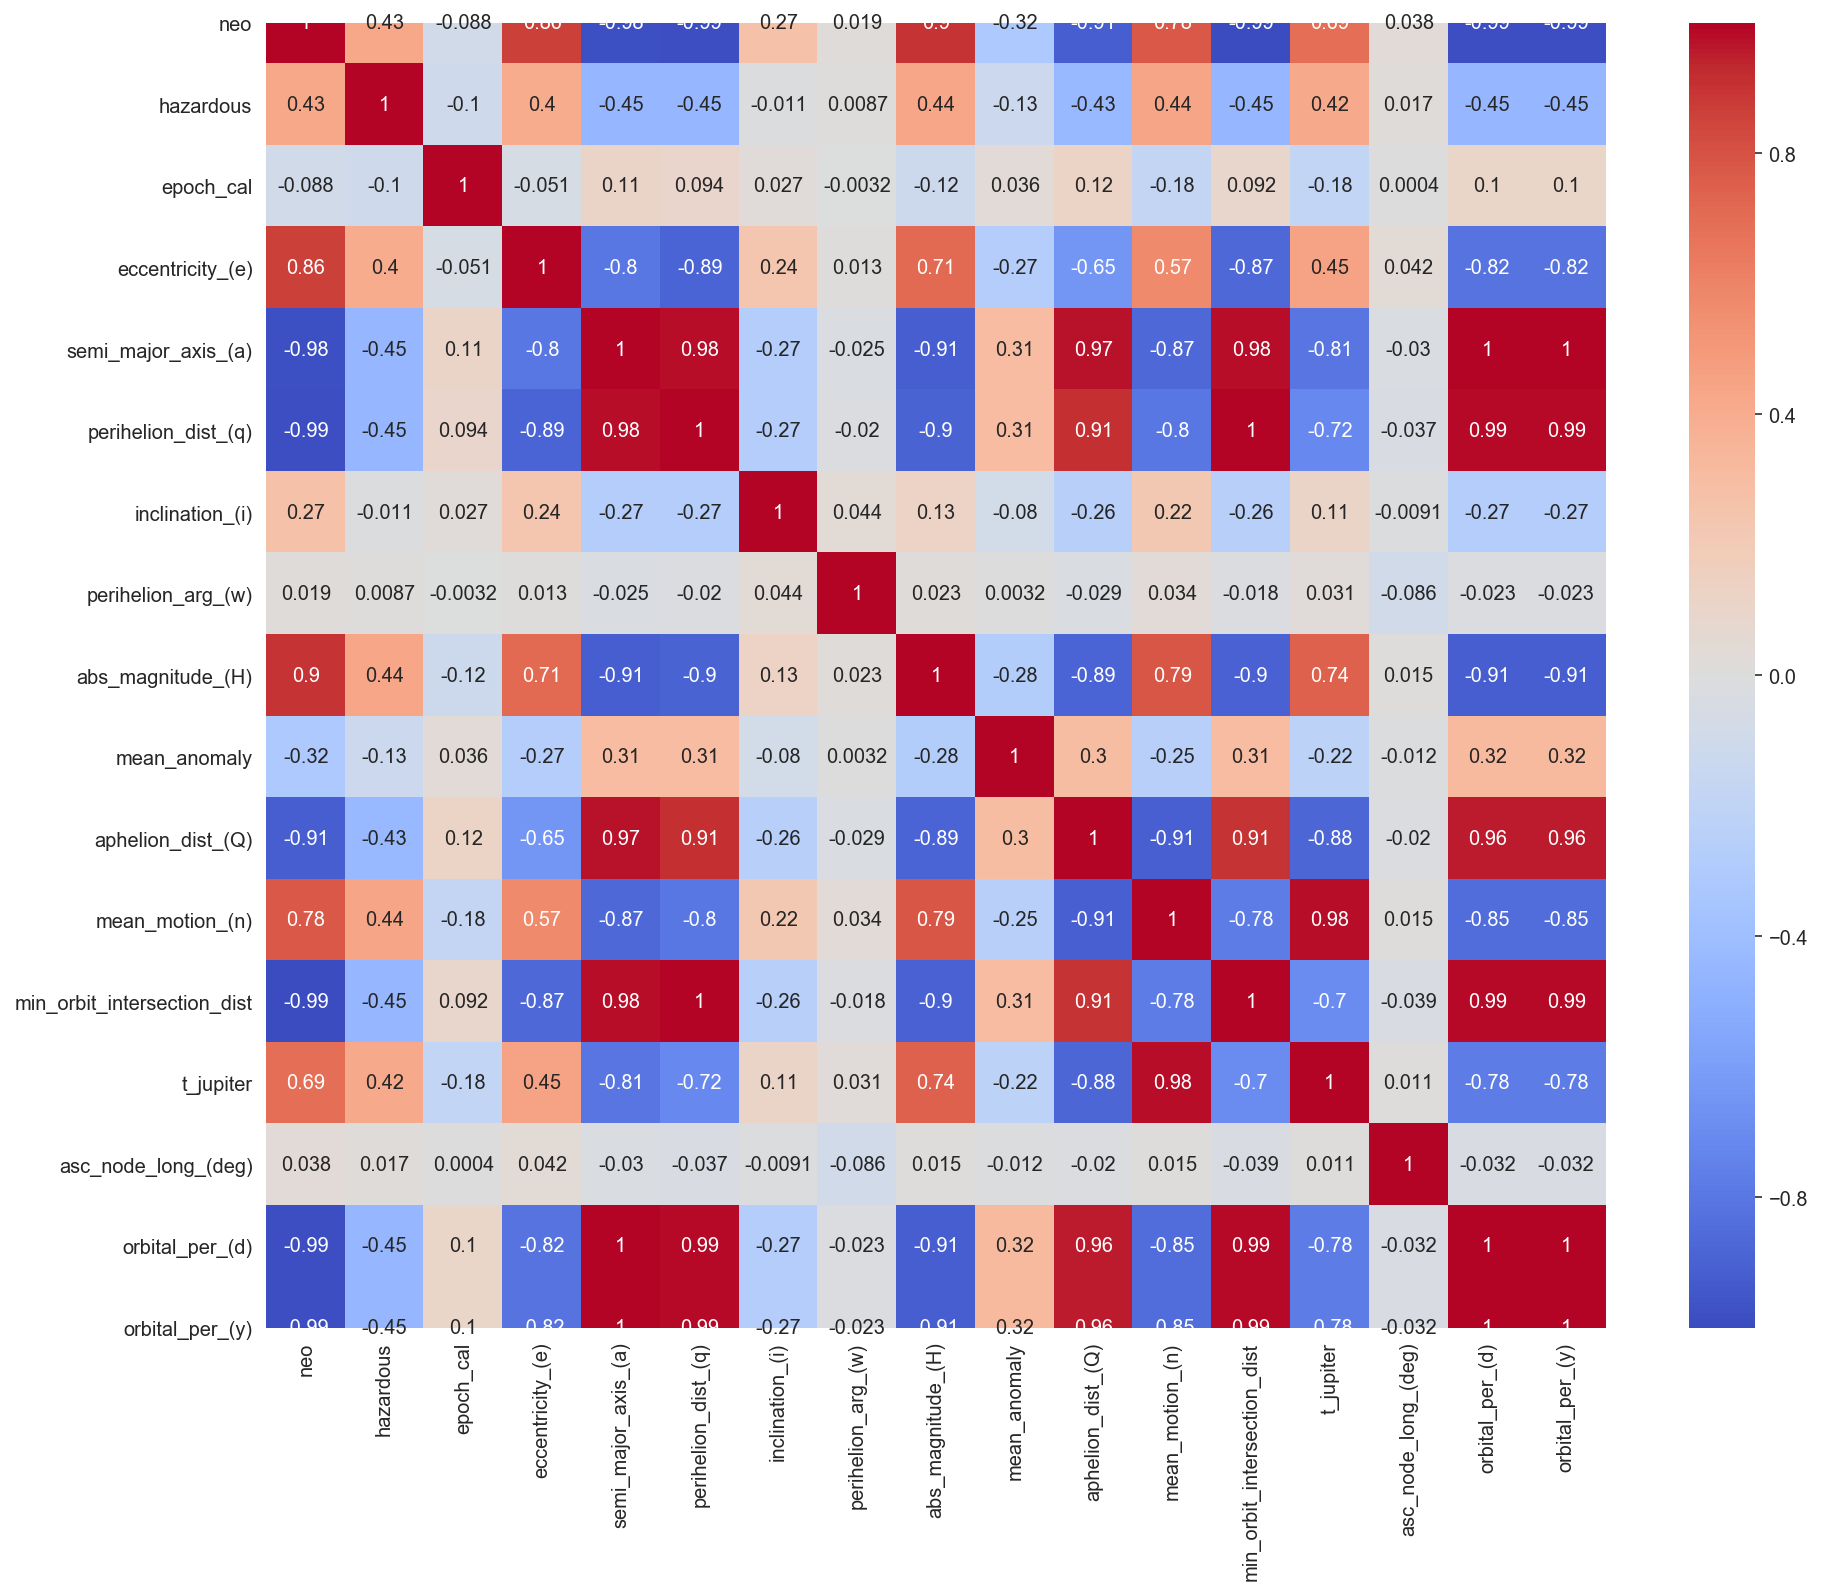

In [30]:
plt.figure(figsize=(15,12))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')

In [31]:
df[['first_obs', 'hazardous']]

first_obs  hazardous
0    1893-10-29          0
1    1906-02-22          0
2    1998-04-22          0
3    1907-02-11          0
4    1908-03-23          0
...         ...        ...
7851 2001-03-25          0
7852 1999-12-12          0
7853 2013-12-28          0
7854 2002-03-10          0
7855 2003-04-24          0

[7856 rows x 2 columns]

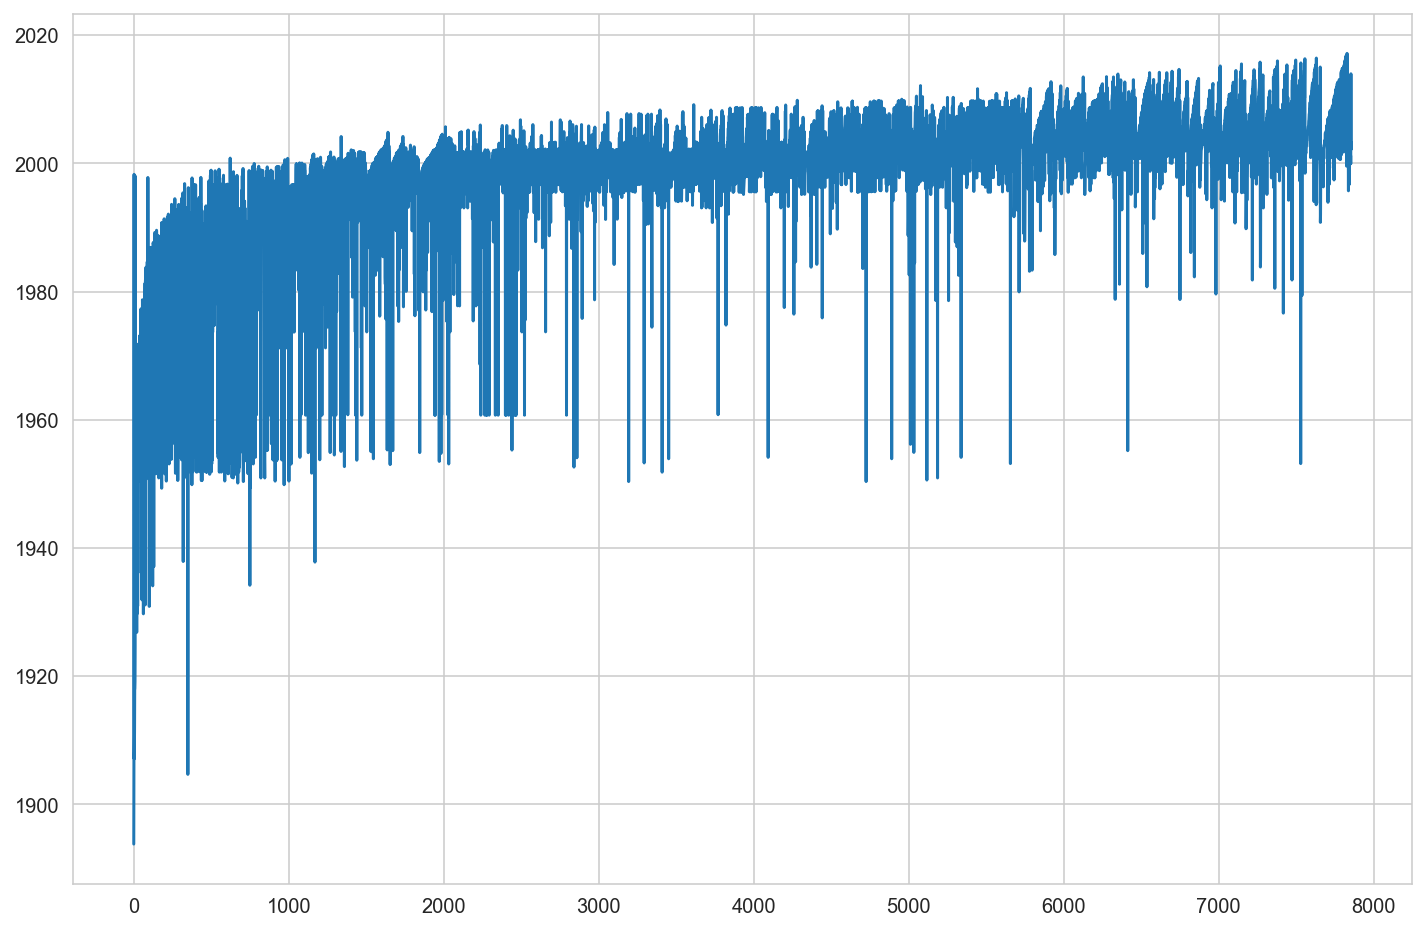

In [32]:
plt.figure(figsize=(12,8))
plt.plot(df['first_obs'])

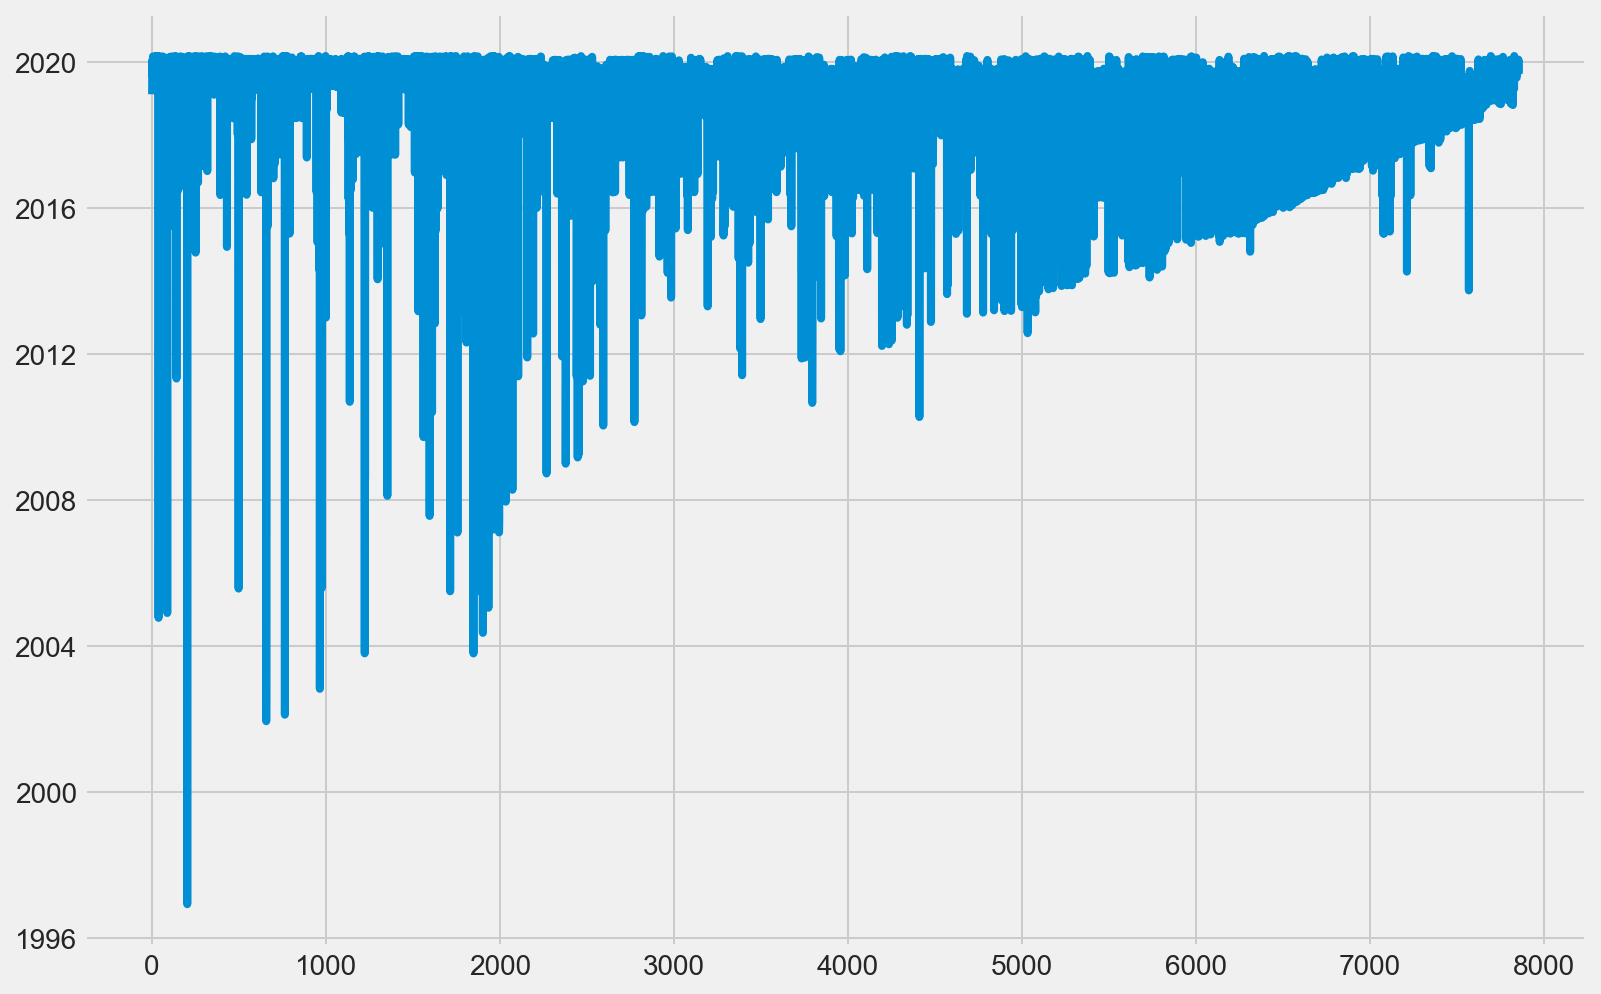

In [34]:
plt.figure(figsize=(12,8))
plt.plot(df['last_obs'])